In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import warnings
from IPython.display import clear_output
from multiprocessing import Pool
from time import time
import json
warnings.filterwarnings('ignore')

In [104]:
data = pd.read_csv('../data/processed/final_data_NO2.csv.gz')
# data = pd.get_dummies(data, columns=['weather', 'wind_direction'])
display(data.head(2), data.tail(2))

,time,station_id,longitude,latitude,NO2_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled
0,2014-05-01 00:00:00,1001,116.173553,40.090679,56.3,0.0,20.0,56.0,7.92,13.0,False
1,2014-05-01 01:00:00,1001,116.173553,40.090679,38.7,0.0,18.0,64.0,7.56,13.0,False


,time,station_id,longitude,latitude,NO2_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled
306598,2015-04-30 22:00:00,1036,116.0,39.579999,23.0,5.0,24.4,47.0,2.7,23.0,False
306599,2015-04-30 23:00:00,1036,116.0,39.579999,23.0,1.0,19.8,72.0,2.6,23.0,True


In [105]:
len(data)

306600

In [106]:
all_stations = data.station_id.unique()
all_stations

array([1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011,
       1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1023,
       1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 1036])

In [107]:
train_division = [0.9, 1.0]
test_division = [0.9, 1.0]

def split_data(data, time_division):
    divided_data = []
    for id, aq_id in data.groupby('station_id'):
        # .interpolate() interpolate noise missing
        station_aq = aq_id

        # split data into train/dev/test
        station_aq = station_aq[int(len(station_aq)*time_division[0]): int(len(station_aq)*time_division[1])]
        divided_data.append(station_aq)
    data = pd.concat(divided_data)
    return data

train_division = split_data(data, train_division)
test_division = split_data(data, test_division)

In [108]:
splitter = KFold(n_splits=3, shuffle=True, random_state=1234)
folder_info = {}

for f_i, (train, test) in enumerate(splitter.split(all_stations)):

    train_stations = all_stations[train]
    test_stations = all_stations[test]
    train_data = train_division[train_division.station_id.isin(train_stations)]

    test_context_data = test_division[test_division.station_id.isin(train_stations)]
    test_target_data = test_division[test_division.station_id.isin(test_stations)]

    train_data.to_csv('../data/NP/fold_'+str(f_i)+'_train_nsgp.csv.gz', index=None)
    test_context_data.to_csv('../data/NP/fold_'+str(f_i)+'_test_context_nsgp.csv.gz', index=None)
    test_target_data.to_csv('../data/NP/fold_'+str(f_i)+'_test_target_nsgp.csv.gz', index=None)

    folder_info[f_i] = {'context': all_stations[train].tolist(),
                      'target': all_stations[test].tolist()}

with open('../data/NP/folder_info.json','w') as file_obj:
    json.dump(folder_info, file_obj)

### Visualize

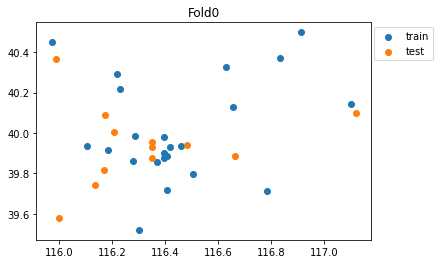

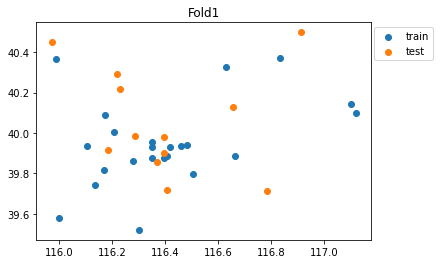

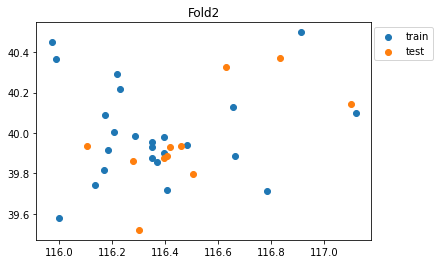

In [109]:
for f_i, (train, test) in enumerate(splitter.split(all_stations)):
    train_stations = all_stations[train]
    test_stations = all_stations[test]
    tmp_trn_df = data[data.station_id.isin(train_stations)].drop_duplicates('station_id')
    tmp_tst_df = data[data.station_id.isin(test_stations)].drop_duplicates('station_id')
    plt.figure()
    plt.title('Fold'+str(f_i))
    plt.scatter(tmp_trn_df['longitude'], tmp_trn_df['latitude'], label='train')
    plt.scatter(tmp_tst_df['longitude'], tmp_tst_df['latitude'], label='test')
    plt.legend(bbox_to_anchor=(1.2,1))

### Add time feature

In [110]:
def get_time_spaced_data(data, start_time):
    data['delta_t'] = np.int64((data.index - start_time).total_seconds() // 3600) + 1
#     data = data.drop(columns=['station_id'])
#     data.index = range(len(data))
    return data

In [121]:
fold=2 # not using for loop to avoid ram overflow
print('fold', fold)

train_data = pd.read_csv('../data/NP/fold_'+str(fold)+'_train_nsgp.csv.gz')
train_data['time'] = pd.to_datetime(train_data['time'])
train_data = train_data.set_index('time').sort_values(['time', 'station_id'])
train_start_time = train_data.index[0]

test_context_data = pd.read_csv('../data/NP/fold_'+str(fold)+'_test_context_nsgp.csv.gz')
test_context_data['time'] = pd.to_datetime(test_context_data['time'])
test_context_data = test_context_data.set_index('time').sort_values(['time', 'station_id'])
test_start_time = test_context_data.index[0]


test_target_data = pd.read_csv('../data/NP/fold_'+str(fold)+'_test_target_nsgp.csv.gz')
test_target_data['time'] = pd.to_datetime(test_target_data['time'])
test_target_data = test_target_data.set_index('time').sort_values(['time', 'station_id'])

fold 2


In [122]:
train_data = get_time_spaced_data(train_data, train_start_time)
test_context = get_time_spaced_data(test_context_data, test_start_time)
test_target = get_time_spaced_data(test_target_data, test_start_time)

In [123]:
display(train_data,test_context,test_target)

,station_id,longitude,latitude,NO2_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled,delta_t
time,,,,,,,,,,,
2015-03-25 12:00:00,1001,116.173553,40.090679,188.4,0.0,16.0,26.0,8.50,23.0,False,1
2015-03-25 12:00:00,1002,116.205310,40.003950,97.5,0.0,16.0,26.0,8.50,23.0,False,1
2015-03-25 12:00:00,1003,116.184239,39.914409,98.0,0.0,15.0,26.0,8.50,13.0,False,1
2015-03-25 12:00:00,1004,116.171150,39.815128,104.3,0.0,16.0,30.0,3.00,2.0,False,1
2015-03-25 12:00:00,1005,116.136045,39.742767,104.8,0.0,15.0,30.0,9.36,23.0,False,1
...,...,...,...,...,...,...,...,...,...,...,...
2015-04-30 23:00:00,1031,115.988000,40.365000,60.9,1.0,17.9,76.0,1.50,14.0,True,876
2015-04-30 23:00:00,1032,116.911000,40.499000,20.0,1.0,17.9,80.0,0.40,14.0,True,876
2015-04-30 23:00:00,1033,117.120000,40.100000,24.0,1.0,19.5,72.0,2.20,13.0,True,876


,station_id,longitude,latitude,NO2_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled,delta_t
time,,,,,,,,,,,
2015-03-25 12:00:00,1001,116.173553,40.090679,188.4,0.0,16.0,26.0,8.50,23.0,False,1
2015-03-25 12:00:00,1002,116.205310,40.003950,97.5,0.0,16.0,26.0,8.50,23.0,False,1
2015-03-25 12:00:00,1003,116.184239,39.914409,98.0,0.0,15.0,26.0,8.50,13.0,False,1
2015-03-25 12:00:00,1004,116.171150,39.815128,104.3,0.0,16.0,30.0,3.00,2.0,False,1
2015-03-25 12:00:00,1005,116.136045,39.742767,104.8,0.0,15.0,30.0,9.36,23.0,False,1
...,...,...,...,...,...,...,...,...,...,...,...
2015-04-30 23:00:00,1031,115.988000,40.365000,60.9,1.0,17.9,76.0,1.50,14.0,True,876
2015-04-30 23:00:00,1032,116.911000,40.499000,20.0,1.0,17.9,80.0,0.40,14.0,True,876
2015-04-30 23:00:00,1033,117.120000,40.100000,24.0,1.0,19.5,72.0,2.20,13.0,True,876


,station_id,longitude,latitude,NO2_Concentration,weather,temperature,humidity,wind_speed,wind_direction,filled,delta_t
time,,,,,,,,,,,
2015-03-25 12:00:00,1010,116.394009,39.876184,138.6,0.0,16.0,30.0,3.00,2.0,False,1
2015-03-25 12:00:00,1012,116.460742,39.937119,116.0,0.0,18.0,12.0,11.88,23.0,False,1
2015-03-25 12:00:00,1013,116.416883,39.929287,102.0,4.0,25.0,46.0,3.24,23.0,False,1
2015-03-25 12:00:00,1016,116.279082,39.863470,111.3,0.0,16.0,30.0,3.00,2.0,False,1
2015-03-25 12:00:00,1018,116.506319,39.794491,93.4,0.0,15.0,34.0,10.44,13.0,False,1
...,...,...,...,...,...,...,...,...,...,...,...
2015-04-30 23:00:00,1025,116.105999,39.936999,44.0,1.0,20.6,70.0,1.80,13.0,True,876
2015-04-30 23:00:00,1026,117.099999,40.143000,26.2,1.0,19.5,72.0,2.20,13.0,True,876
2015-04-30 23:00:00,1027,116.628000,40.328000,34.0,1.0,18.7,80.0,1.10,24.0,True,876


In [124]:
display(train_data.shape, test_context.shape, test_target.shape)

(21024, 11)

(21024, 11)

(9636, 11)

In [125]:
train_data.reset_index().to_csv('../data/NP/time_feature/fold'+str(fold)+'/train_data_nsgp.csv.gz', index=None)
test_context.reset_index().to_csv('../data/NP/time_feature/fold'+str(fold)+'/test_context_data_nsgp.csv.gz', index=None)
test_target.reset_index().to_csv('../data/NP/time_feature/fold'+str(fold)+'/test_target_data_nsgp.csv.gz', index=None)